<h1><strong><u>MLP Test</u></strong></h1>

In [8]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB, CategoricalNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import spacy

<h2><u>Data Preprocessing</u></h2>

In [9]:
df = pd.DataFrame(columns=["title", "target"])

In [10]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [11]:
data = df.sample(frac=1, random_state=42).reset_index(drop=True)
display(data)

,title,target
0,Filipino activist arrested for disrupting Mani...,non clickbait
1,"International Board fixes soccer field size, h...",non clickbait
2,24 Rules For Women On A First Date With A Man,clickbait
3,Political fallout from the sacking of Professo...,non clickbait
4,"Which ""Clueless"" Character Are You Based On Yo...",clickbait
...,...,...
31995,Rocket strike near hotel in Afghan capital inj...,non clickbait
31996,How Well Do You Remember The First Episode Of ...,clickbait
31997,16 Photos From The Delhi Queer Pride Parade Th...,clickbait
31998,33 Of The Most Canadian Sentences Ever,clickbait


In [12]:
X = data["title"]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600,)

(6400,)

(25600,)

(6400,)

<h2><u>Data Vectorization</u></h2>

In [13]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h4><u>Cross Validation Testing</u></h4>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END clf__hidden_layer_sizes=(4,);, score=(train=0.954, test=0.931) total time=  14.8s
[CV] END clf__hidden_layer_sizes=(4,);, score=(train=0.954, test=0.935) total time=  18.8s
[CV] END clf__hidden_layer_sizes=(8,);, score=(train=0.959, test=0.941) total time=  19.5s
[CV] END clf__hidden_layer_sizes=(8,);, score=(train=0.957, test=0.935) total time=  21.4s
[CV] END clf__hidden_layer_sizes=(12,);, score=(train=0.959, test=0.939) total time=  43.2s
[CV] END clf__hidden_layer_sizes=(12,);, score=(train=0.957, test=0.933) total time=  44.6s
[CV] END clf__hidden_layer_sizes=(4,);, score=(train=0.956, test=0.939) total time=  16.8s
[CV] END clf__hidden_layer_sizes=(16,);, score=(train=0.959, test=0.940) total time= 1.1min
[CV] END clf__hidden_layer_sizes=(20,);, score=(train=0.958, test=0.937) total time= 1.2min
[CV] END clf__hidden_layer_sizes=(16,);, score=(train=0.959, test=0.933) total time=  57.2s
[CV] END clf__hidden_layer_sizes=(24,);, score=(train=0.953, test=0.935) total time= 

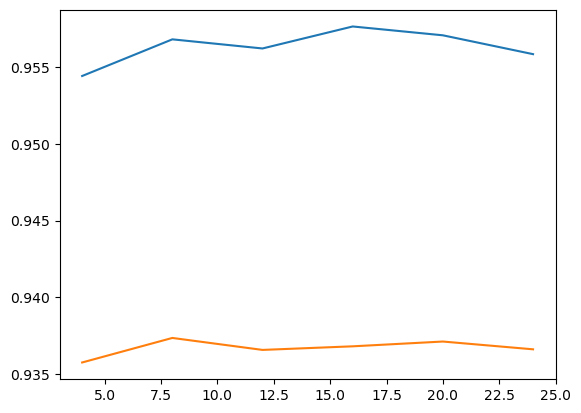

In [22]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", MLPClassifier(alpha=1)),
    ]
)
hidden_layers = [(4,), (8,), (12,), (16,), (20,), (24,)]
numbers = list(range(4, 25, 4))
alphas = list(range(1,11))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__hidden_layer_sizes",
                                                   param_range=hidden_layers,
                                                   verbose=3,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(numbers, train_scores_mean)
plt.plot(numbers, validation_scores_mean)

<h2><u>Conclusion From Validation Curve</u></h2>

The general shape of this plot suggests that regardless of complexity of the model in terms of the number of neurons per layer shows the accuracy of both train and validation scores will remain proportional to each other. I believe this is due to the alphas value of 1 for the model. I believe these are good results and can be further tested in the GridSearchCV.